# Classification of Sugarcane Diseases based on Images

## Initial Setup

Examining the train data shows that there are six (6) classes in total:

In [1]:
classes = [
    "Banded_Chlorosis",
    "Brown_Rust",
    "Brown_Spot",
    "Viral",
    "Yellow_Leaf",
    "Healthy",
]

classes.sort()
print(classes)

['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Healthy', 'Viral', 'Yellow_Leaf']


## Data Loading and Preprocessing



In [2]:
from pathlib import Path
from pprint import pprint

import keras
import numpy as np
import tensorflow as tf

SEED = 1738  # To make random outcomes reproducible
TRAIN_DIRECTORY = Path("./train")


train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="rgb",
    batch_size=None,  # type: ignore
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
)


def get_class_distribution(
    dataset, include_class_mappings: bool = False
) -> tuple[dict[int, int], dict[int, str]]:
    class_count = {}
    class_mappings = {}
    class_names = []
    if include_class_mappings:
        class_names = dataset.class_names

    for _, label in dataset:
        label_np = label.numpy()
        if len(class_names) > 0 and class_mappings.get(label_np) is None:
            class_mappings[label_np] = class_names[label_np]
        if class_count.get(label_np) is None:
            class_count[label_np] = 1
            continue
        class_count[label_np] += 1
    return class_count, class_mappings


class_count_train, class_mappings = get_class_distribution(train_ds, True)
class_count_validation, _ = get_class_distribution(validation_ds)

# pprint(class_count_train)
pprint(class_mappings)
# print(f"MINIMUM: {minimum_class}, {minimum_class_count} ")

2025-05-26 20:12:23.281193: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 20:12:23.454627: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 20:12:23.588662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748261543.702850  110684 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748261543.734867  110684 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748261544.057033  110684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Found 4314 files belonging to 6 classes.
Using 3452 files for training.
Using 862 files for validation.


2025-05-26 20:12:29.170246: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-26 20:12:31.915606: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{np.int32(0): 'Banded_Chlorosis',
 np.int32(1): 'Brown_Rust',
 np.int32(2): 'Brown_Spot',
 np.int32(3): 'Healthy',
 np.int32(4): 'Viral',
 np.int32(5): 'Yellow_Leaf'}


2025-05-26 20:12:32.504680: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
# Compute class weights
# Combine train_ds and val_ds class counts
total_images = sum(class_count_train.values()) + sum(class_count_validation.values())
weights = {}
for key in class_count_train:
    # new_key = np.fromstring(key.strip("[]"), dtype=float, sep=" ").argmax()
    weights[key] = total_images / (
        (class_count_train[key] + class_count_validation[key]) * len(classes)
    )
pprint(weights)
# print(sum(weights.values()))


# Batch the data set for model compatibility
# Prefetch to optimize
def config_performance(dataset: tf.data.Dataset, batch_size):
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(tf.data.AUTOTUNE)

{np.int32(0): 1.695754716981132,
 np.int32(1): 2.549645390070922,
 np.int32(2): 0.4638709677419355,
 np.int32(3): 1.8578811369509043,
 np.int32(4): 1.204355108877722,
 np.int32(5): 0.6694599627560521}


## Method 1: Convolution Neural Network (CNN)

The first method for solving this classification problem is through the use of CNN.

We will be using the Keras and TensorFlow libraries.

First, let us setup the environment and model.

In [ ]:
import keras
import matplotlib.pyplot as plt
from keras.api import applications

EPOCHS = 30
DROPOUT_RATE = 0.2
BATCH_SIZE = 128
IMAGE_SIZE = 96

# Repeated here to prepare images with correct IMAGE_SIZE
train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,  # type: ignore
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
    verbose=False,
)

train_ds_optimized = config_performance(train_ds, BATCH_SIZE)
validation_ds_optimized = config_performance(validation_ds, BATCH_SIZE)

models = [
    # applications.InceptionV3,
    # applications.ResNet50V2,
    # applications.ResNet50,
    applications.InceptionResNetV2,
    # applications.MobileNetV3Large,
    # applications.MobileNetV3Small,
]

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.001, patience=2, mode="auto", restore_best_weights=True # type: ignore
)

for model in models:
    pre_trained_model = model(
        weights="imagenet",
        classes=len(classes),
        include_top=False,  # the fully connected layer at the end
    )

    model_label = f"{pre_trained_model.name}-{EPOCHS}"
    print(model_label)

    for layer in pre_trained_model.layers:
        layer.trainable = False

    transfer_model = keras.models.Sequential(
        [
            # preprocessing layers
            keras.layers.Rescaling(1.0 / 255),
            # data augmentation layers
            # keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
            # keras.layers.RandomBrightness(factor=0.2, seed=SEED),
            # keras.layers.RandomContrast(factor=0.1, seed=SEED),
            pre_trained_model,
            # fully connected
            # keras.layers.Flatten(),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dropout(DROPOUT_RATE),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dropout(DROPOUT_RATE),
            keras.layers.Dense(len(classes), activation="softmax"),
        ]
    )

    # transfer_model.summary()

    transfer_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="Accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(name="TopK", k=len(classes)//2),
        ],
    )

    history = transfer_model.fit(
        train_ds_optimized,
        epochs=EPOCHS,
        validation_data=validation_ds_optimized,
        class_weight=weights,
        callbacks=[early_stop],
    )

    transfer_model.save(f"./results/models/{model_label}.keras")

Using 3452 files for training.
Using 862 files for validation.
inception_resnet_v2-30
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - Accuracy: 0.3800 - TopK: 0.7150 - loss: 1.8523 - val_Accuracy: 0.6415 - val_TopK: 0.9466 - val_loss: 0.9200
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - Accuracy: 0.7195 - TopK: 0.9553 - loss: 0.6737 - val_Accuracy: 0.7796 - val_TopK: 0.9872 - val_loss: 0.5862
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - Accuracy: 0.8337 - TopK: 0.9830 - loss: 0.4163 - val_Accuracy: 0.8480 - val_TopK: 0.9919 - val_loss: 0.4331
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - Accuracy: 0.8649 - TopK: 0.9901 - loss: 0.3450 - val_Accuracy: 0.8515 - val_TopK: 0.9768 - val_loss: 0.4393
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - Accuracy: 0.9069 - TopK: 0.9912 - loss: 0.2724 - val_Accuracy: 0.8689 - val_TopK: 0.9930 - val_loss: 0.3683
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - Accuracy: 0.8925 - TopK: 0.9945 - loss: 0.2478 - val_Accuracy:

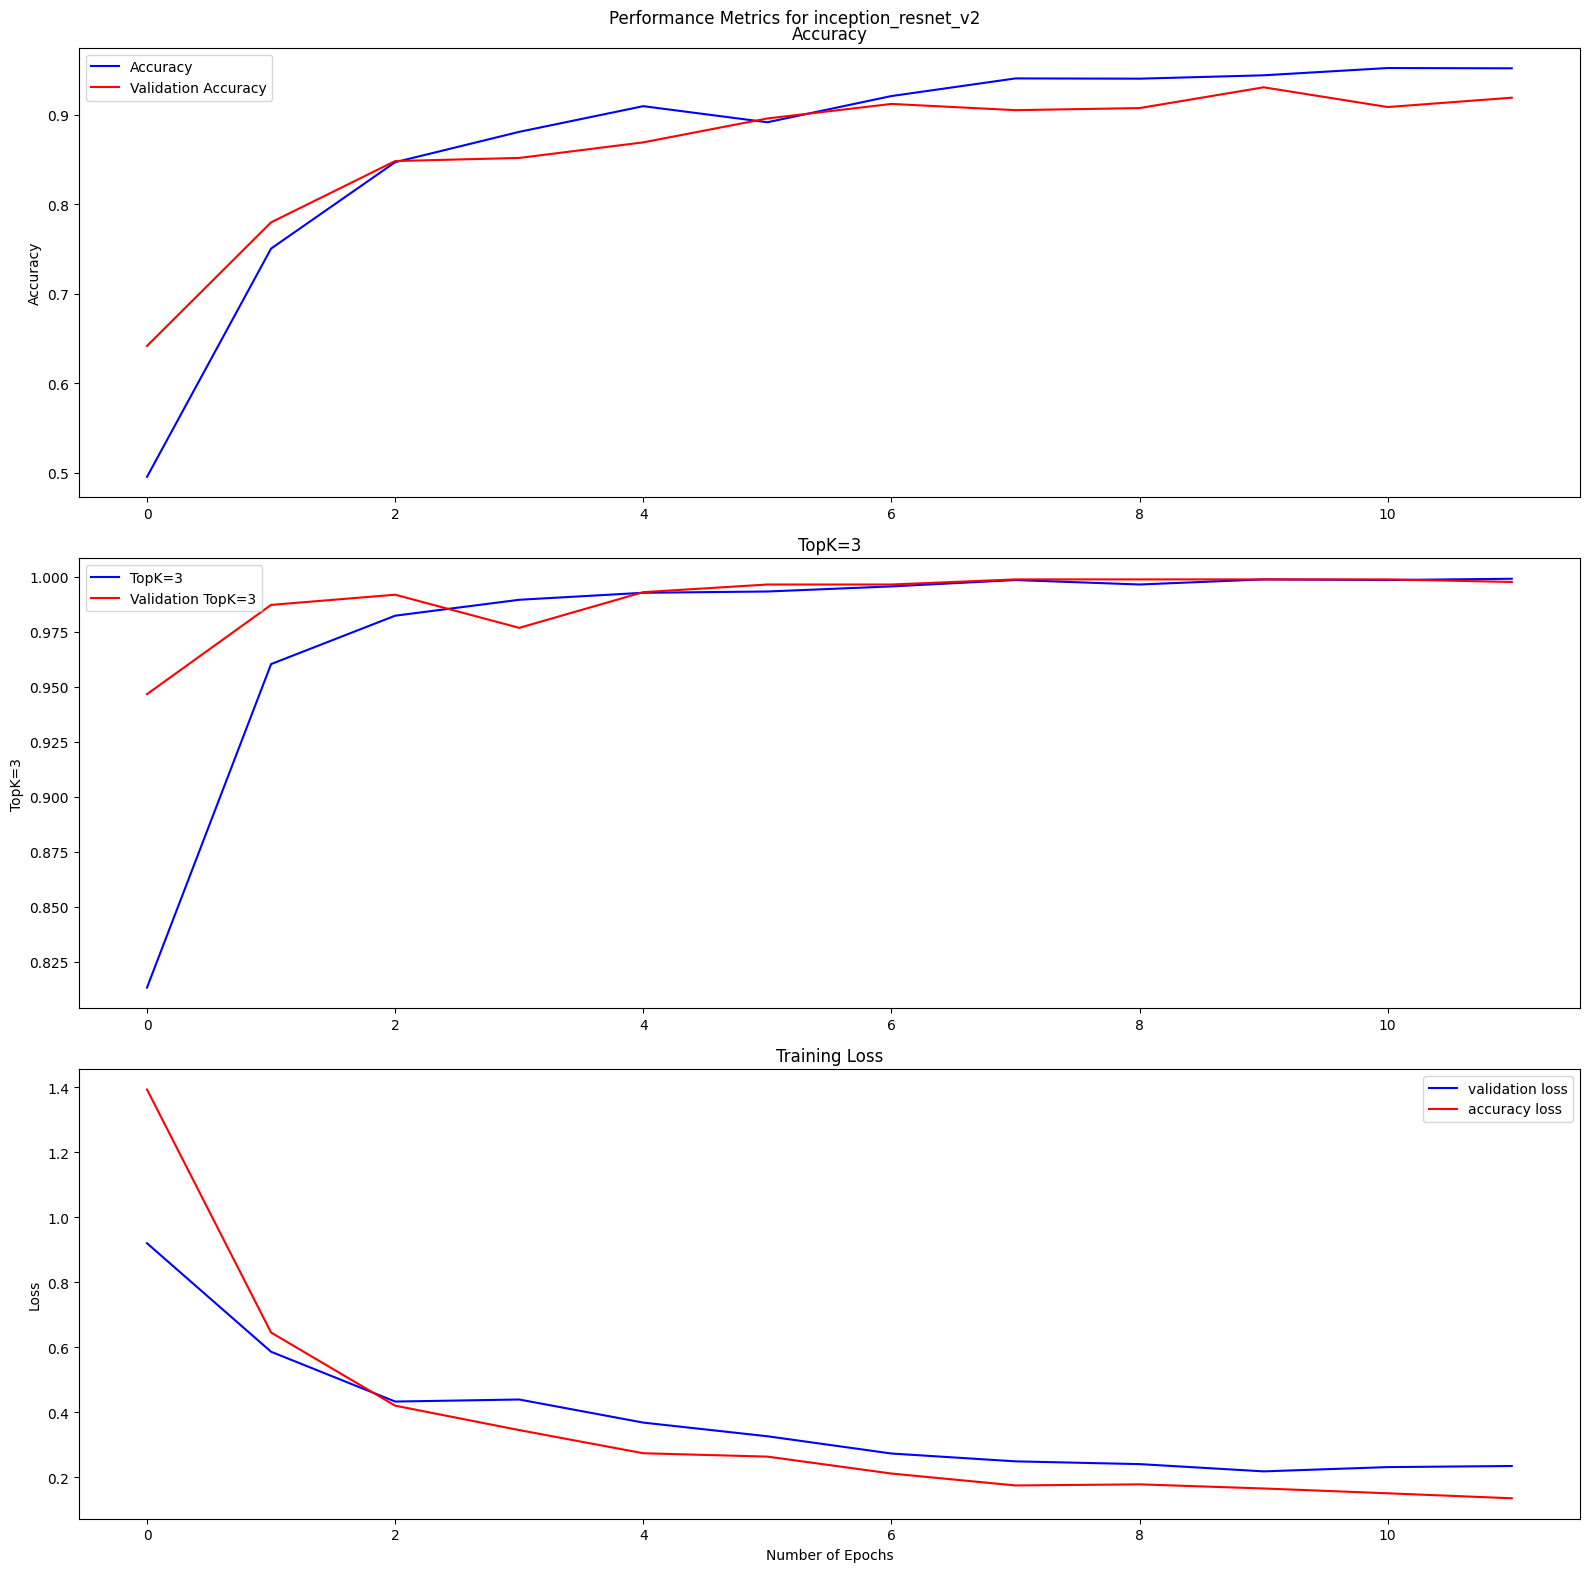

In [12]:
def generate_metric_plots(history):
    fig, axs = plt.subplots(3)
    fig.set_size_inches(w=16, h=16)
    fig.set_layout_engine("tight")
    fig.suptitle(f"Performance Metrics for {pre_trained_model.name}")
    axs[0].plot(history.history["Accuracy"], color="b", label="Accuracy")
    axs[0].plot(history.history["val_Accuracy"], color="r", label="Validation Accuracy")
    axs[0].set_title("Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # show the f1_score
    topK = f"TopK={len(classes)//2}"
    axs[1].plot(history.history["TopK"], color="b", label=topK)
    axs[1].plot(history.history["val_TopK"], color="r", label=f"Validation {topK}")
    axs[1].set_title(topK)
    axs[1].set_ylabel(topK)
    axs[1].legend()

    # show the training (and validation) loss
    axs[2].plot(history.history["val_loss"], color="b", label="validation loss")
    axs[2].plot(history.history["loss"], color="r", label="accuracy loss")
    axs[2].set_title("Training Loss")
    axs[2].set_xlabel("Number of Epochs")
    axs[2].set_ylabel("Loss")
    axs[2].legend()
    plt.show()
    fig.savefig(f"./results/graph/{model_label}.png")


generate_metric_plots(history)

In [6]:
transfer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 1, 1, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,225,652 (237.37 MB)

 Trainable params: 2,629,638 (10.03 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

 Optimizer params: 5,259,278 (20.06 MB)

## Method 2: Vision Transformer

In [5]:
import keras_hub

EPOCHS = 3
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
IMAGE_SIZE = 64
PRESET = "vit_base_patch16_224_imagenet21k"

# Repeated here to prepare images with correct IMAGE_SIZE
train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,  # type: ignore
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
    verbose=False,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.001, patience=2, mode="auto", restore_best_weights=True # type: ignore
)

train_ds_optimized = config_performance(train_ds, BATCH_SIZE)
validation_ds_optimized = config_performance(validation_ds, BATCH_SIZE)

vit_backbone = keras_hub.models.Backbone.from_preset(PRESET, load_weights=True)

vit_backbone.layers[-1].trainable = False  # freeze encoder layer

vit_backbone.summary()

transfer_model = keras.models.Sequential(
    [
        # preprocessing layers
        keras_hub.layers.ViTImageConverter.from_preset(PRESET),
        # data augmentation layers
        # keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
        # keras.layers.RandomBrightness(factor=0.2, seed=SEED),
        # keras.layers.RandomContrast(factor=0.1, seed=SEED),
        vit_backbone,
        # fully connected
        # keras.layers.Flatten(),
        keras.layers.GlobalAveragePooling1D(),
        # keras.layers.Dense(1024, activation="relu"),
        # keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(len(classes), activation="softmax"),
    ]
)

# transfer_model.summary()

transfer_model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="Accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(name="TopK", k=len(classes)//2),
    ],
)  # type: ignore
transfer_model.summary()

history = transfer_model.fit(
    train_ds_optimized,
    epochs=EPOCHS,
    validation_data=validation_ds_optimized,
    class_weight=weights,
    callbacks=[early_stop],
)

Using 3452 files for training.
Using 862 files for validation.


Model: "vi_t_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vit_patching_and_embedding      │ (None, 197, 768)       │       742,656 │
│ (ViTPatchingAndEmbedding)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vit_encoder (ViTEncoder)        │ (None, 197, 768)       │    85,056,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,798,656 (327.30 MB)

 Trainable params: 742,656 (2.83 MB)

 Non-trainable params: 85,056,000 (324.46 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vi_t_image_converter            │ ?                      │   0 (unbuilt) │
│ (ViTImageConverter)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_backbone (ViTBackbone)     │ (None, 197, 768)       │    85,798,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,798,656 (327.30 MB)

 Trainable params: 742,656 (2.83 MB)

 Non-trainable params: 85,056,000 (324.46 MB)

Epoch 1/3


/home/ubuntu/CS180-Project/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:1410: UserWarning: Layer 'vi_t_image_converter' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''ViTImageConverter.call() missing 1 required positional argument: 'x'''
  warnings.warn(
/home/ubuntu/CS180-Project/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'vi_t_image_converter', however the layer does not have

  2/108 ━━━━━━━━━━━━━━━━━━━━ 37:47 21s/step - Accuracy: 0.2109 - TopK: 0.5938 - loss: 1.9697

KeyboardInterrupt: 